In [1]:
import pickle; import tensorflow as tf; import pandas as pd
import matplotlib.pyplot as plt ; import datetime; from datetime import datetime
#print(tf.version)
import bz2; import random; import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import warnings; from sklearn import metrics
import seaborn as sns; import itertools
warnings.filterwarnings('ignore')
###
import os; import os.path; from glob import glob
import random; import shutil
from tqdm.auto import tqdm
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
#from kerashypetune import KerasGridSearch
from numpy import mean; from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import eigh; import plotly.express as px; 

In [2]:
def FIPS_function(row):
    state = str(row['stateFip']).zfill(2)
    county = str(row['countyFip']).zfill(3)
    return str(state + county)


def get_above_threshold_2(dff,target,thresh):
    
    corr_mtrx = dff.corr(); corr_vals = corr_mtrx.values
    flds = list(corr_mtrx.columns); numCols = corr_mtrx.shape[0]
    
    above_threshold = []
    for i in range(numCols):
        for j in range(i+1, numCols):
            if corr_vals[i,j] > thresh:
                if i != j:
                    above_threshold.append([flds[i],flds[j],corr_vals[i,j]])
    above_threshold.sort(reverse=True)
    
    #above = [above.append(i) for i in above_threshold if i[0] == target or if i[1] == target:]
    list_above = []
    for i in above_threshold:
        if i[0] == target or i[1] == target:
            list_above.append(i)
            
    return corr_mtrx, list_above


def get_suggestions(dff,num,methodd):
    
    # get correlation matrix using desired method
    og_corr_mtrx = dff.corr(method=methodd); corr_vals = og_corr_mtrx.values
    flds = list(og_corr_mtrx.columns); numCols = og_corr_mtrx.shape[0]; 
    target_corrs = []; target = 'JHU_ConfirmedCases.data'
    
    # iterate throughout matrix and get all correlations associated with target
    for i in range(numCols):
        for j in range(i+1, numCols):
            if i != j:
                if flds[i] == target or flds[j] == target:
                    target_corrs.append([flds[i],flds[j],corr_vals[i,j]])
    
    # convert corrs to df, sort by correlations and keep only the number of desried rows 
    s_corrs = pd.DataFrame(target_corrs,columns=['col1','col2','corr'])
    s_corrs = s_corrs.sort_values(by='corr', ascending=False).head(num)
    s_corrs.reset_index(drop=True); suggestion_lst=[]
    
    # put the names of columns into a list
    for i, j in s_corrs.iterrows():
        if j["col1"] != target:
            suggestion_lst.append(j['col1'])
        if j['col2'] != target:
            suggestion_lst.append(j['col2'])
            
    return suggestion_lst, s_corrs, og_corr_mtrx

In [3]:
file_name = '/Users/evanfalkowski/Documents/Drexel/Capstone/DSCI_592/workspace/feeFiFoFum.pbz2'
bz_file = bz2.BZ2File(file_name,'rb'); df = pd.read_pickle(bz_file)
cols = ['NYT_ConfirmedCases.data','NYT_ConfirmedDeaths.data','NYT_ConfirmedDeaths.missing','county','LND110210','countyStateName','stateFip','countyFip']
df.drop(cols, axis=1, inplace=True); raw_df = df.copy()
print(df.shape,raw_df.shape); df.head(3)

(1879589, 88) (1879589, 88)


,dates,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,TotalPopulation.data,MaleAndFemale_AtLeast65_Population.data,Male_Total_Population.data,Female_Total_Population.data,MaleAndFemale_Under18_Population.data,BLS_EmployedPopulation.data,BLS_EmployedPopulation.missing,...,hoursWorkedMean,unitsInStructure,healthInsTotal,healthInsNativeWith,healthInsForeignNatWith,healthInsForeignNoncitWith,healthInsForeignNatNo,healthInsForeignNoncitNo,healthInsNativeNo,pm25
0,2020-03-19,1.0,0.0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,...,38.1,12191,24397,21415,179,87,39,122,2555,9.618551
1,2020-03-20,1.0,0.0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,...,38.1,12191,24397,21415,179,87,39,122,2555,9.618551
2,2020-03-21,1.0,0.0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,...,38.1,12191,24397,21415,179,87,39,122,2555,9.618551


In [4]:
print(raw_df.shape,raw_df.isnull().sum().sum())
raw_df = raw_df.dropna(); raw_df = raw_df.reset_index(drop = True)
raw_df = raw_df.drop(columns='dates')
print(raw_df.shape,raw_df.isnull().sum().sum())

(1879589, 88) 380
(1879209, 87) 0


## PCA
- https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
- at 95% variance

In [34]:
target = 'JHU_ConfirmedCases.data'
features = list(raw_df.columns) 

x_df = raw_df.loc[:, features].values
x_df = StandardScaler().fit_transform(x_df)
y_df = raw_df.loc[:,[target]].values

pca = PCA(); principalComponents = pca.fit_transform(x_df)
principalDf = pd.DataFrame(data = principalComponents)

pca_df = pd.concat([principalDf, raw_df[[target]]], axis = 1)
print(pca_df.shape); pca_df.head(3)

(1879209, 88)


,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,JHU_ConfirmedCases.data
0,-1.564139,-0.755117,-0.114888,-1.106719,1.002595,-0.397365,0.042617,-0.152608,0.450444,-1.201397,...,1.217559e-14,-1.339001e-14,-6.837584e-16,2.001022e-14,-2.146018e-14,2.834464e-16,7.881675e-15,-9.945185e-14,-7.165531e-15,1.0
1,-1.555596,-0.668478,-0.153416,-0.987555,0.759823,-0.344670,-0.085902,-0.395554,-0.247785,-0.968838,...,-2.602005e-14,-5.600070e-14,-9.525339e-15,-4.425394e-14,-1.444669e-15,4.271694e-14,1.369225e-14,2.418320e-13,5.991649e-14,1.0
2,-1.554759,-0.599130,-0.167944,-0.869562,0.644037,-0.347350,-0.083119,-0.295409,-0.248425,-0.975986,...,-1.599064e-14,-6.221446e-16,4.145507e-15,3.205565e-14,-7.640593e-15,-1.820712e-16,7.692143e-15,-6.519218e-14,-1.172969e-14,1.0


#### Number of suggested compnents
    - if components not set, all components are kept

In [36]:
var_expln = list(pca.explained_variance_ratio_); var_expln.sort(reverse=True)
print('Number of principle compnents: ', len(var_expln))
print('Original number of compnents: ', raw_df.shape[1])

Number of principle compnents:  87


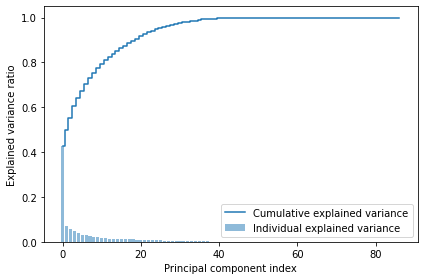

In [37]:
cum_sum_eigenvalues = np.cumsum(var_expln)

plt.bar(range(0,len(var_expln)), var_expln, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index'); plt.legend(loc='best')
plt.tight_layout(); plt.show()

In [87]:
#exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

#px.area(
#    x=range(1, exp_var_cumul.shape[0] + 1),
#    y=exp_var_cumul,
#    labels={"x": "# Components", "y": "Explained Variance"}
#)

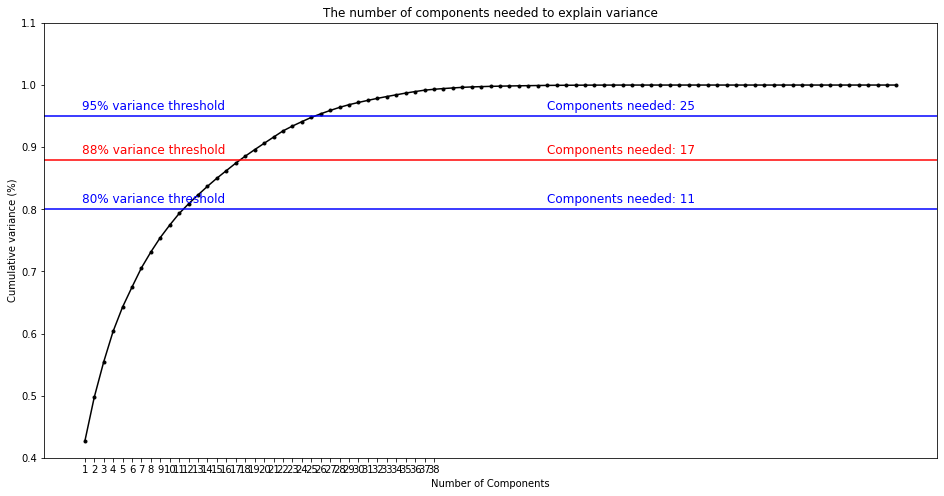

In [139]:
# Plot the cumulative variance for each component
#https://statisticallyrelevant.com/principal-component-analysis-in-python/
plt.figure(figsize = (16, 8))
components = np.arange(1, 88, step=1)
variance = np.cumsum(pca.explained_variance_ratio_)
plt.ylim(0.4,1.1)
plt.plot(components, variance, marker='.', linestyle='-', color='black')
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 39, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')
#95%
plt.axhline(y=0.95, color='b', linestyle='-')
plt.text(0.75, 0.96, '95% variance threshold', color = 'blue', fontsize=12)
plt.text(50, 0.96, "Components needed: "+str(np.where(np.cumsum(pca.explained_variance_ratio_)>=0.95)[0][0]), color = "blue", fontsize=12)
#90%
plt.axhline(y=0.88, color='r', linestyle='-')
plt.text(0.75, 0.89, '88% variance threshold', color = 'red', fontsize=12)
plt.text(50, 0.89, "Components needed: "+str(np.where(np.cumsum(pca.explained_variance_ratio_)>=0.88)[0][0]), color = "red", fontsize=12)
#80%
plt.axhline(y=0.80, color='b', linestyle='-')
plt.text(0.75, 0.81, '80% variance threshold', color = 'blue', fontsize=12)
plt.text(50, 0.81, "Components needed: "+str(np.where(np.cumsum(pca.explained_variance_ratio_)>=0.80)[0][0]), color = "blue", fontsize=12)
plt.show()

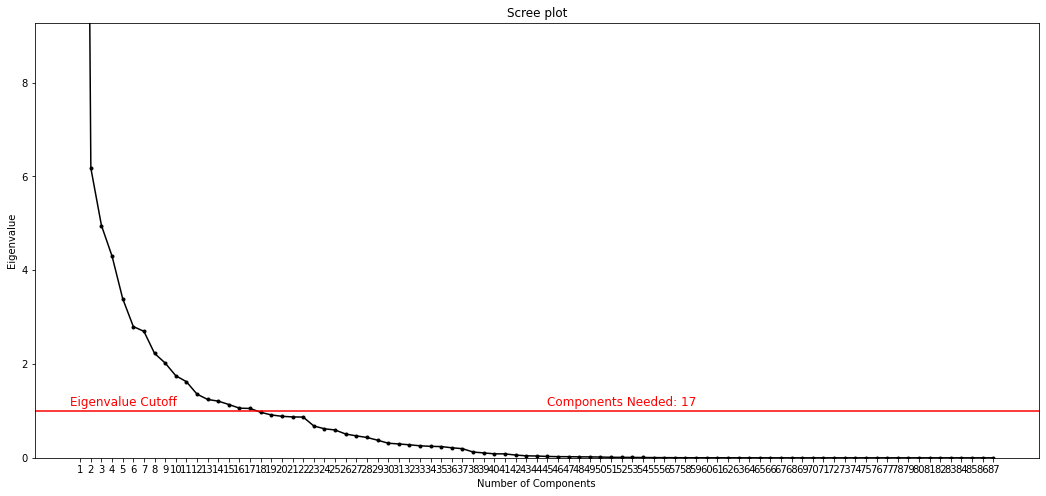

In [78]:
# Scree plot


plt.figure(figsize=(18, 8))
components = np.arange(1, 88, step=1)
eigenvalues = pca.explained_variance_
plt.plot(components, eigenvalues, marker = '.', linestyle = '-', color = 'black')
#plt.ylim(0, max(eigenvalues))
plt.ylim(0, max(eigenvalues)/4)
plt.ylabel('Eigenvalue')
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 88, step = 1))
plt.title('Scree plot')
plt.axhline(y=1, color = 'r', linestyle = '-')
plt.text(0, 1.11, 'Eigenvalue Cutoff', color = 'red', fontsize=12)
plt.text(45, 1.11, 'Components Needed: '+str(np.where(eigenvalues<=1)[0][0]), 
                 color = 'red', fontsize=12)
plt.show()

The above scree plot contains the eigenvalues on the y axis and the number of components 
on the x axis. A general rule of thumb, is to keep number of components that have an 
eigenvalue greater than 1. The scree plot suggests to keep 17 components. 

## Suggestions from correlations and components

#### Pearson

In [81]:
p_suggestions, p_suggestion_df, p_corr_matrx = get_suggestions(raw_df,17,'pearson')
print(p_suggestion_df.head(2));print('---');print(p_suggestion_df.tail(2))

                      col1                         col2      corr
0  JHU_ConfirmedCases.data     JHU_ConfirmedDeaths.data  0.957832
6  JHU_ConfirmedCases.data  BLS_EmployedPopulation.data  0.782552
---
                       col1              col2      corr
76  JHU_ConfirmedCases.data  unitsInStructure  0.763475
66  JHU_ConfirmedCases.data     houseFamily65  0.763316


#### Spearman

In [82]:
s_suggestions, s_suggestion_df, s_corr_matrx = get_suggestions(raw_df,17,'spearman')
print(s_suggestion_df.head(2));print('---');print(s_suggestion_df.tail(2))

                       col1                        col2      corr
0   JHU_ConfirmedCases.data    JHU_ConfirmedDeaths.data  0.949478
41  JHU_ConfirmedCases.data  jhu_daily_cases_rolling_30  0.783351
---
                       col1         col2      corr
69  JHU_ConfirmedCases.data  house2+No65  0.614664
62  JHU_ConfirmedCases.data   totalTrans  0.612343


## List of suggestions
- I used pearson and spearman correlation to give me the top correlated features
- Using the number of suggested components from pca to determine number of returned features

In [83]:
p_suggestions #pearson

['JHU_ConfirmedDeaths.data',
 'BLS_EmployedPopulation.data',
 'BLS_LaborForcePopulation.data',
 'healthInsTotal',
 'totalMoved',
 'Female_Total_Population.data',
 'TotalPopulation.data',
 'latestTotalPopulation',
 'Male_Total_Population.data',
 'MaleAndFemale_Under18_Population.data',
 'totalTrans',
 'houseFamilyNo65',
 'householdStructuresTotal',
 'householdsTotal',
 'house2+No65',
 'unitsInStructure',
 'houseFamily65']

In [84]:
s_suggestions #spearman

['JHU_ConfirmedDeaths.data',
 'jhu_daily_cases_rolling_30',
 'jhu_daily_new_cases_rolling_30',
 'jhu_daily_new_cases_rolling_7',
 'jhu_daily_cases_rolling_7',
 'jhu_daily_death_rolling_30',
 'MaleAndFemale_Under18_Population.data',
 'totalMoved',
 'Male_Total_Population.data',
 'TotalPopulation.data',
 'latestTotalPopulation',
 'houseFamilyNo65',
 'healthInsTotal',
 'Female_Total_Population.data',
 'houseNo65',
 'house2+No65',
 'totalTrans']

In [85]:
print('difference between spearman and pearson')
print(list(set(s_suggestions).difference(p_suggestions))) # difference between spearman and pearson
print('difference between pearson and spearman')
print(list(set(p_suggestions).difference(s_suggestions))) # difference between pearson and spearman

difference between spearman and pearson
['houseNo65', 'jhu_daily_new_cases_rolling_7', 'jhu_daily_death_rolling_30', 'jhu_daily_cases_rolling_7', 'jhu_daily_cases_rolling_30', 'jhu_daily_new_cases_rolling_30']
difference between pearson and spearman
['houseFamily65', 'BLS_EmployedPopulation.data', 'householdsTotal', 'BLS_LaborForcePopulation.data', 'householdStructuresTotal', 'unitsInStructure']


In [30]:
#p_suggestion_df; #s_suggestion_df

### Other dimensionality techniques
 - #https://towardsdatascience.com/dimensionality-reduction-with-python-d3fac4e57c71
 - #https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
 - #https://www.learndatasci.com/tutorials/applied-dimensionality-reduction-techniques-using-python/
 - #https://statisticallyrelevant.com/principal-component-analysis-in-python/

In [88]:
###from above 
#target = 'JHU_ConfirmedCases.data'; features = list(raw_df.columns) 
#x_df = raw_df.loc[:, features].values; x_df = StandardScaler().fit_transform(x_df)
#y_df = raw_df.loc[:,[target]].values

pca_2 = PCA(n_components=0.99, whiten=True)
features_pca = pca_2.fit_transform(x_df)

print("Original number of features:", raw_df.shape[1])
print("Reduced number of features:", features_pca.shape[1])

Original number of features: 87
Reduced number of features: 37


In [101]:
###Irrelevant features in classification

#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import chi2, f_classif

#xx = raw_df[features].astype(int)
#chi2_selector = SelectKBest(chi2, k=17)
#features_kbest = chi2_selector.fit_transform(xx,raw_df[target])
# Show results
#print("Original number of features:", raw_df.shape[1])
#print("Reduced number of features:", features_kbest.shape[1])

##error x must be non-negative

In [103]:
#### recursive feature elimination
import warnings;from sklearn.feature_selection import RFECV;from sklearn import linear_model

# Generate features matrix, target vector, and the true coefficients
#features, target = make_regression(n_samples = 10000, n_features = 100, n_informative = 2, random_state = 1)
lr = linear_model.LinearRegression()

# Recursively eliminate features
rfecv = RFECV(estimator=lr, step=1, scoring="neg_mean_squared_error")
rfecv.fit(raw_df[features], raw_df[target])
rfecv.transform(raw_df[features])


array([[1.0, 0.0],
       [1.0, 0.0],
       [1.0, 0.0],
       ...,
       [501.0, 0.0],
       [501.0, 0.0],
       [501.0, 0.0]], dtype=object)

In [122]:
##https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
print(rfecv); print(rfecv.n_features_, rfecv.n_features_in_)
rfecv.ranking_

RFECV(estimator=LinearRegression(), scoring='neg_mean_squared_error')
2 87


array([ 1, 44, 61, 21, 75, 73, 65, 86, 41, 81, 36, 27, 43, 82, 42, 38, 25,
       32, 35, 24, 30, 29, 37, 12, 34, 14, 69, 48, 28, 52, 26, 49, 33, 31,
       76, 85, 17, 47, 45, 78, 40, 39, 15, 54, 60,  1,  4,  2, 59,  3,  5,
        6,  9,  7,  8, 10, 11, 16, 46, 20, 56, 71, 57, 79, 77, 74, 22, 53,
       51, 80, 19, 68, 62, 64, 72, 84, 13, 83, 18, 58, 67, 70, 63, 55, 50,
       66, 23])

In [128]:
### support masks the variable if you should use it or not, masks with true or false
for i in range(rfecv.n_features_in_):
    if rfecv.support_[i] == True:
        print(rfecv.feature_names_in_[i])
        

JHU_ConfirmedCases.data
jhu_death_rate


In [136]:
## ranking ranks the variables of usefulness, 1 to the # of features you have
### set to pca suggestion number of components
for i in range(rfecv.n_features_in_):
    if rfecv.ranking_[i] <= 18:
        print(rfecv.feature_names_in_[i])

JHU_ConfirmedCases.data
AveragePrecipitationTotal.data
AveragePrecipitation.data
jhu_daily_death
jhu_daily_death_rolling_30
jhu_death_rate
jhu_case_rate
jhu_new_case_rate
icu_beds_per_person
staffed_beds_per_person
licensed_beds_per_person
cold_days
hot_days
moderate_days
gte_65_percent
lt_18_percent
employed_percent
gini
unitsInStructure


In [140]:
## trying this next --> #RFECV visualizer with a linear SVM classifier

#from sklearn.svm import SVC; from yellowbrick.model_selection import RFECV
#visualizer = RFECV(SVC(kernel='linear', C=1))
#visualizer.fit(raw_df[features], raw_df[target]) # Fit the data to the visualizer
#visualizer.show()   # Finalize and render the figure